# Investigation of Station Data from Bay Area Bike Share Published Data

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [6]:
from investigationutils import time_marker as tm
from investigationutils import csv_chunk_importer

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

DO_WRITE_CHARTS = True

# Load Morning and Evening Commuter Trips Data

In [12]:
trip_data_columns = ['junk', 'trip_id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'user_type', 'user_zip', 'duration_minutes',
       'billed_minutes', 'billed_periods', 'is_commuter']

In [13]:
trips = csv_chunk_importer(file_path_slug='../../clean_data/bayareabikeshare/sf_trips_data_3hr_cleaned_tagged.csv', 
                           column_labels=trip_data_columns, 
                           chunk_size=10000)

trips.drop('junk', axis=1, inplace=True)

trips['start_date'] = pd.to_datetime(trips['start_date'])
trips['end_date'] = pd.to_datetime(trips['end_date'])

[00:59:40.518913] Started Loading Data...
[00:59:46.109827] Finished file! (1 of 1)
[00:59:46.109936] concatenating chunks...
[00:59:46.688766] Data Loaded Successfully!


In [18]:
morning_commutes = trips[trips.is_commuter == 'am_commuter'].copy()
morning_commutes.reset_index(inplace=True, drop=True)
evening_commutes = trips[trips.is_commuter == 'pm_commuter'].copy()
evening_commutes.reset_index(inplace=True, drop=True)

# Analysis - Station Commuter Traffic
<p>Find Most Start and End Terminals</p>
<p></p>

## Calculate morning and evening traffic in and out of each station

In [19]:
def station_traffic(df=None):
    traffic = pd.DataFrame()

    # count trips starting at each terminal 
    traffic = df.groupby('start_station_id')['trip_id'].count().to_frame()
    traffic.columns = ['outbound_traffic']

    # calculate share of all trip starts for each terminal
    traffic['outbound_share'] = traffic['outbound_traffic'] / traffic['outbound_traffic'].sum() * 100.

    # count trips ending at each terminal
    traffic['inbound_traffic'] = df.groupby('end_station_id')['trip_id'].count().to_frame()

    # calculate share of all trip ends for each terminal
    traffic['inbound_share'] = traffic['inbound_traffic'] / traffic['inbound_traffic'].sum() * 100.

    # set index to terminal id
    traffic.index.name = 'station_id'
    return traffic

In [20]:
morning_station_traffic = station_traffic(df=morning_commutes)
morning_station_traffic.head()

,outbound_traffic,outbound_share,inbound_traffic,inbound_share
station_id,,,,
39,5233,2.054421,4990,1.959022
41,1273,0.499766,6678,2.621713
42,2904,1.140080,5582,2.191434
45,1818,0.713728,7423,2.914192
46,1570,0.616365,1669,0.655232


In [21]:
evening_station_traffic = station_traffic(df=evening_commutes)
evening_station_traffic.head(5)

,outbound_traffic,outbound_share,inbound_traffic,inbound_share
station_id,,,,
39,4610,1.941617,6742,2.839562
41,5830,2.455450,1405,0.591751
42,5125,2.158522,3459,1.456844
45,7085,2.984025,1751,0.737477
46,1404,0.591330,2200,0.926585


# Graphical EDA of Morning Traffic

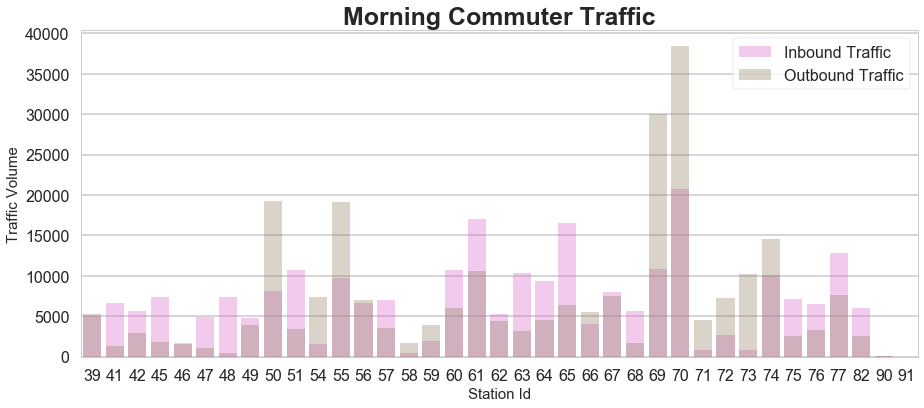

In [22]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=morning_station_traffic.index, y=morning_station_traffic.inbound_traffic, color=commuter_am, alpha=0.35, label='Inbound Traffic')
sns.barplot(x=morning_station_traffic.index, y=morning_station_traffic.outbound_traffic, color=commuter_am_alt, alpha=0.35, ax=ax, label='Outbound Traffic')
ax.legend(loc=1, frameon=True)
ax.set_title('Morning Commuter Traffic', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Station Id', size=LABEL_FONT_SIZE)
ax.set_ylabel('Traffic Volume', size=LABEL_FONT_SIZE)
plt.show()
# plt.savefig('../../charts/station_trends/morning_commuter_traffic.png')
plt.close()

# Graphical EDA of Evening Traffic

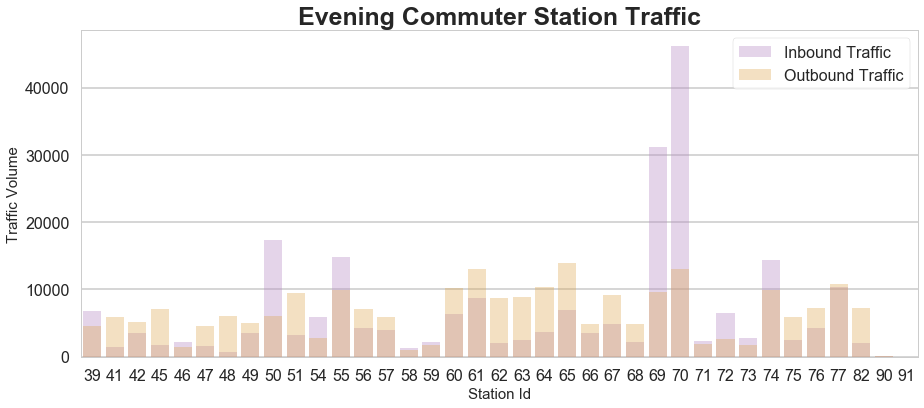

In [23]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=evening_station_traffic.index, y=evening_station_traffic.inbound_traffic, color=commuter_pm, alpha=0.35, label='Inbound Traffic')
sns.barplot(x=evening_station_traffic.index, y=evening_station_traffic.outbound_traffic, color=commuter_pm_alt, alpha=0.35, ax=ax, label='Outbound Traffic')
ax.legend(loc=1, frameon=True)
ax.set_title('Evening Commuter Station Traffic', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Station Id', size=LABEL_FONT_SIZE)
ax.set_ylabel('Traffic Volume', size=LABEL_FONT_SIZE)
plt.show()
# plt.savefig('../../charts/station_trends/evening_commuter_traffic.png')
plt.close()

# Graphical EDA of Day Count Adjusted Traffic
<p>Not all stations have been open the same amount of time, adjust numbers to a mean traffic per commuter day</p>

## Load Station Data

In [32]:
stations = pd.read_csv('../../clean_data/bayareabikeshare/sf_station_data_cleaned.csv', 
                       index_col=0, parse_dates=['first_service_date', 'last_service_date'])

# stations = stations[stations.region == 'San Francisco'].copy()
# stations.reset_index(inplace=True, drop=True)

# station 73 was expanded, we dont care about that right now, we just want days open.
# copy last_service_date from second entry to first, need total days
stations.iloc[29,7] = stations.iloc[30,7]
# add days in sevice to second entry to first entry 
stations.iloc[29,9] += stations.iloc[30,9]
# drop second entry
stations.drop_duplicates(subset=['station_id'], inplace=True)

stations.reset_index(inplace=True, drop=True)
stations.head()

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,39,Powell Street BART,37.783871,-122.408433,19,San Francisco,2013-08-29,2016-08-31,94107,1098,10.338920,33.920340
1,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,2013-08-29,2016-08-31,94107,1098,3.082564,10.113399
2,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.519689,8.266697
3,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,2013-08-29,2016-08-31,94107,1098,4.575804,15.012480
4,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,2013-08-29,2016-08-31,94107,1098,10.850125,35.597524


# Calculate Number of Commuter Days each station has been in service

In [33]:
def weekdays_in_service(row):
    return pd.date_range(start=row.first_service_date, end=row.last_service_date, freq='B').shape[0]

In [34]:
stations['commuter_days'] = stations.apply(lambda row: weekdays_in_service (row), axis=1)

# Calculate Mean Traffic Per Day

In [35]:
def trips_per_day(row, trips_df=None, which=''):
    '''Get numebr of trips started or ended at each station between stations first and last day of service only'''

    station_first_service_date = row.first_service_date
    station_last_service_date  = row.last_service_date
    
    if which == 'start':
        tmp = trips_df[(trips_df.start_station_id == row.station_id) &
                       (trips_df.start_date >= row.first_service_date) &
                       (trips_df.start_date < row.last_service_date)]
        return tmp.shape[0]
    
    if which == 'end':
        tmp = trips_df[(trips_df.end_station_id == row.station_id) &
                       (trips_df.start_date >= row.first_service_date) &
                       (trips_df.start_date < row.last_service_date)]
        return tmp.shape[0]
    

In [36]:
# append data from only trips by morning commuters
stations['morning_outbound_commuter_traffic'] = stations.apply(lambda row: trips_per_day (row, trips_df=morning_commutes, which='start'), axis=1)
stations['morning_inbound_commuter_traffic'] = stations.apply(lambda row: trips_per_day (row, trips_df=morning_commutes, which='end'), axis=1)

# append data from only trips by morning commuters
stations['evening_outbound_commuter_traffic'] = stations.apply(lambda row: trips_per_day (row, trips_df=evening_commutes, which='start'), axis=1)
stations['evening_inbound_commuter_traffic'] = stations.apply(lambda row: trips_per_day (row, trips_df=evening_commutes, which='end'), axis=1)

stations.head()

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet,commuter_days,morning_outbound_commuter_traffic,morning_inbound_commuter_traffic,evening_outbound_commuter_traffic,evening_inbound_commuter_traffic
0,39,Powell Street BART,37.783871,-122.408433,19,San Francisco,2013-08-29,2016-08-31,94107,1098,10.338920,33.920340,785,5227,4985,4604,6736
1,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,2013-08-29,2016-08-31,94107,1098,3.082564,10.113399,785,1273,6671,5822,1403
2,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.519689,8.266697,785,2900,5576,5120,3457
3,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,2013-08-29,2016-08-31,94107,1098,4.575804,15.012480,785,1816,7408,7075,1748
4,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,2013-08-29,2016-08-31,94107,1098,10.850125,35.597524,785,1570,1666,1400,2198


In [37]:
# append data from only trips by morning commuters
stations['morning_outbound_commuter_traffic_per_day'] = stations.morning_outbound_commuter_traffic / stations.commuter_days
stations['morning_inbound_commuter_traffic_per_day'] = stations.morning_inbound_commuter_traffic / stations.commuter_days

# append data from only trips by morning commuters
stations['evening_outbound_commuter_traffic_per_day'] = stations.evening_outbound_commuter_traffic / stations.commuter_days
stations['evening_inbound_commuter_traffic_per_day'] = stations.evening_inbound_commuter_traffic / stations.commuter_days

stations.head()

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,...,elevation_feet,commuter_days,morning_outbound_commuter_traffic,morning_inbound_commuter_traffic,evening_outbound_commuter_traffic,evening_inbound_commuter_traffic,morning_outbound_commuter_traffic_per_day,morning_inbound_commuter_traffic_per_day,evening_outbound_commuter_traffic_per_day,evening_inbound_commuter_traffic_per_day
0,39,Powell Street BART,37.783871,-122.408433,19,San Francisco,2013-08-29,2016-08-31,94107,1098,...,33.920340,785,5227,4985,4604,6736,6.658599,6.350318,5.864968,8.580892
1,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,2013-08-29,2016-08-31,94107,1098,...,10.113399,785,1273,6671,5822,1403,1.621656,8.498089,7.416561,1.787261
2,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,2013-08-29,2016-08-31,94107,1098,...,8.266697,785,2900,5576,5120,3457,3.694268,7.103185,6.522293,4.403822
3,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,2013-08-29,2016-08-31,94107,1098,...,15.012480,785,1816,7408,7075,1748,2.313376,9.436943,9.012739,2.226752
4,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,2013-08-29,2016-08-31,94107,1098,...,35.597524,785,1570,1666,1400,2198,2.000000,2.122293,1.783439,2.800000


# Graphical EDA of Morning Traffic - Mean Per Day

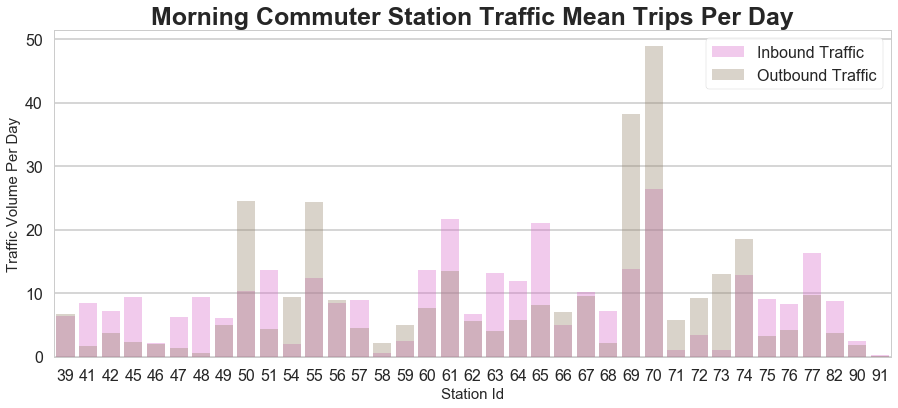

In [38]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=stations.station_id, y=stations.morning_inbound_commuter_traffic_per_day, color=commuter_am, alpha=0.35, label='Inbound Traffic')
sns.barplot(x=stations.station_id, y=stations.morning_outbound_commuter_traffic_per_day, color=commuter_am_alt, alpha=0.35, ax=ax, label='Outbound Traffic')
ax.legend(loc=1, frameon=True)

ax.set_title('Morning Commuter Station Traffic Mean Trips Per Day', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Station Id', size=LABEL_FONT_SIZE)
ax.set_ylabel('Traffic Volume Per Day', size=LABEL_FONT_SIZE)
plt.show()
# plt.savefig('../../charts/station_trends/morning_commuter_traffic_daily_mean.png')
plt.close()

# Graphical EDA of Evening Traffic - Mean Per Day

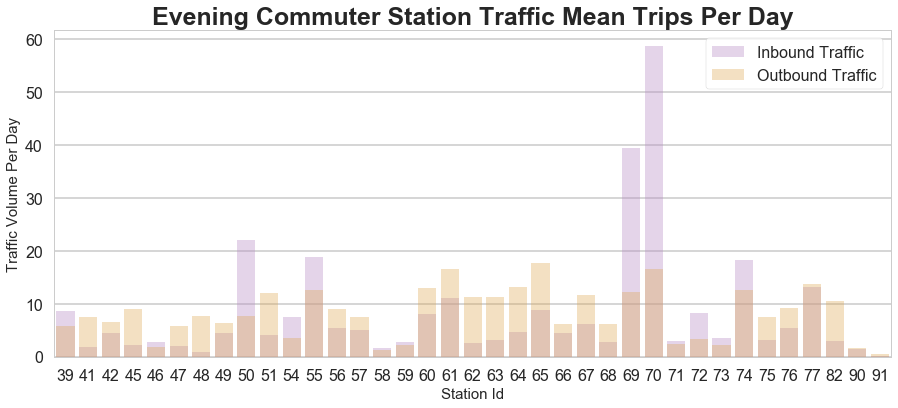

In [39]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=stations.station_id, y=stations.evening_inbound_commuter_traffic_per_day, color=commuter_pm, alpha=0.35, label='Inbound Traffic')
sns.barplot(x=stations.station_id, y=stations.evening_outbound_commuter_traffic_per_day, color=commuter_pm_alt, alpha=0.35, ax=ax, label='Outbound Traffic')
ax.legend(loc=1, frameon=True)

ax.set_title('Evening Commuter Station Traffic Mean Trips Per Day', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Station Id', size=LABEL_FONT_SIZE)
ax.set_ylabel('Traffic Volume Per Day', size=LABEL_FONT_SIZE)
plt.show()
# plt.savefig('../../charts/station_trends/evening_commuter_traffic_daily_mean.png')
plt.close()

# Identify Popular Morning Commuter Routes
<p> A Route is a trip from Station A to Station B</p>

In [40]:
def make_route_grid(trip_df=None, station_ids=stations.station_id):
    index   = [x for x in station_ids]
    columns = [x for x in station_ids]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    # morning_trip_grid

    # create grid of trips from start to end terminal counts
    for sid in station_ids:
        for eid in station_ids:
            # count trips between terminals
            route_count = trip_df[(trip_df.start_station_id == sid) & (trip_df.end_station_id == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_count

    trip_grid = trip_grid.iloc[::-1]    
    return trip_grid

In [41]:
def make_outbound_grid(trip_df=None, station_ids=stations.station_id):
    index   = [x for x in station_ids]
    columns = [x for x in station_ids]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    # morning_trip_grid

    # create grid of trips from start to end terminal counts
    for sid in station_ids:
        route_count = trip_df[(trip_df.start_station_id == sid)].shape[0]
        trip_grid.loc[eid, sid] = route_count

    trip_grid = trip_grid.iloc[::-1]    
    return trip_grid

In [42]:
def make_inbound_grid(trip_df=None, station_ids=stations.station_id):
    index   = [x for x in station_ids]
    columns = [x for x in station_ids]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    # morning_trip_grid

    # create grid of trips from start to end terminal counts
    for eid in station_ids:
        # count trips between terminals
        route_count = trip_df[(trip_df.end_station_id == eid)].shape[0]
        trip_grid.loc[eid, sid] = route_count

    trip_grid = trip_grid.iloc[::-1]    
    return trip_grid

# Morning Commute Route Popularity

In [43]:
morning_trip_grid = make_route_grid(trip_df=morning_commutes, station_ids=stations.station_id)
print('morning_trip_grid 95th Percentile  {:2.6f}'.format(morning_trip_grid.mean().mean() + 2*morning_trip_grid.std().std()))

morning_trip_grid 95th Percentile  692.437548


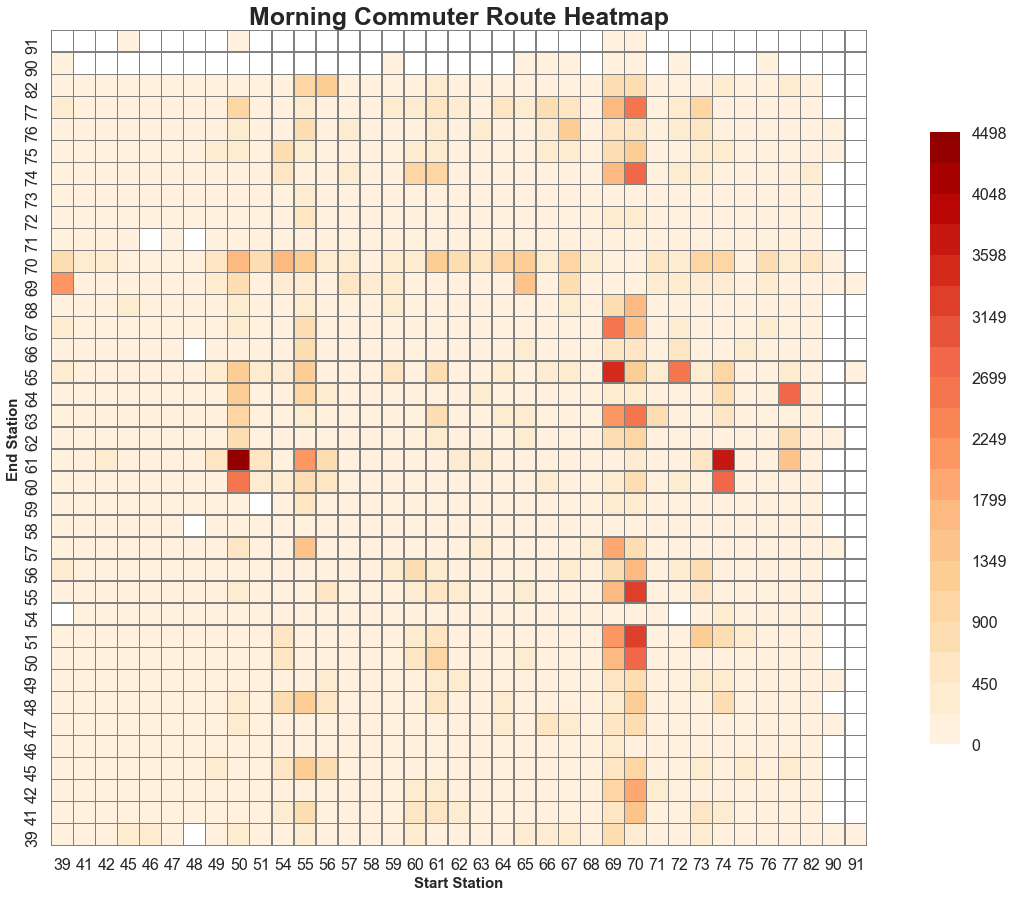

In [44]:
mask = morning_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = morning_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=morning_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('OrRd', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commuter Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
plt.show()
# plt.savefig('../../charts/station_trends/morning_commuter_route_heatmap.png')
plt.close()

# Evening Commute Route Popularity

In [45]:
evening_trip_grid = make_route_grid(trip_df=evening_commutes, station_ids=stations.station_id)
print('evening_trip_grid 95th Percentile  {:2.6f}'.format(evening_trip_grid.mean().mean() + 2*evening_trip_grid.std().std()))

evening_trip_grid 95th Percentile  616.726596


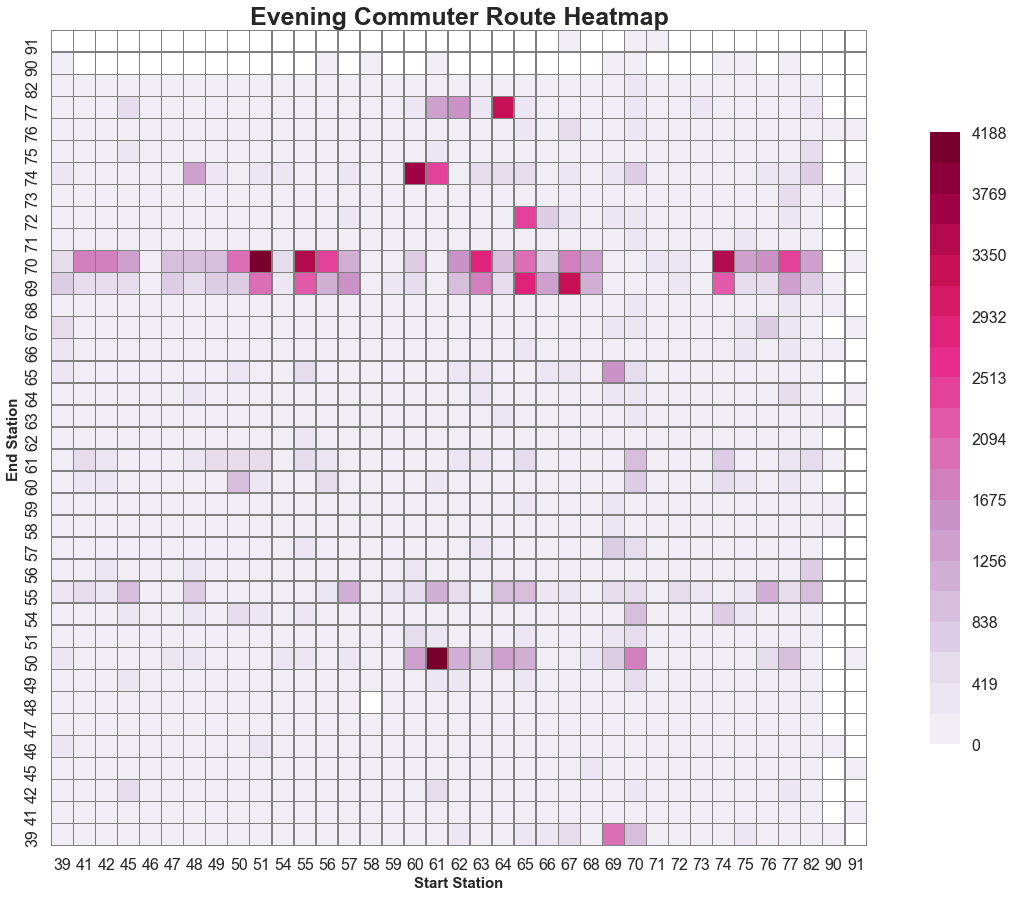

In [46]:
mask = evening_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = evening_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=evening_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('PuRd', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commuter Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
plt.show()
# plt.savefig('../../charts/station_trends/evening_commuter_route_heatmap.png')
plt.close()

# Top Stations by Traffic

In [24]:
for col in stations.columns:
    if '_commuter_traffic' in col:
        
        top_stations = list(stations.sort_values([col], ascending=False).head(10)['station_id'])
        total_trips = stations[col].sum()
        
        print('\nTop Stations - %s' % col.replace('_', ' ').title())
        for sid in top_stations:
            s_name = str(list(stations[stations.station_id == sid]['station_name'])[0]).strip()
            trips = list(stations[stations.station_id == sid][col])[0]
            trip_share = trips / total_trips*100.
            print('\t{:2d}\t{:5.3f}\t{:5.3f}\t{}'.format(sid, trips, trip_share, s_name))


Top Stations - Morning Outbound Commuter Traffic
	70	38443.000	15.093	San Francisco Caltrain (Townsend at 4th)
	69	30007.000	11.781	San Francisco Caltrain 2 (330 Townsend)
	50	19277.000	7.568	Harry Bridges Plaza (Ferry Building)
	55	19176.000	7.528	Temporary Transbay Terminal (Howard at Beale)
	74	14548.000	5.712	Steuart at Market
	61	10585.000	4.156	2nd at Townsend
	73	10216.000	4.011	Grant Avenue at Columbus Avenue
	77	7626.000	2.994	Market at Sansome
	67	7545.000	2.962	Market at 10th
	54	7354.000	2.887	Embarcadero at Bryant

Top Stations - Morning Inbound Commuter Traffic
	70	20708.000	8.130	San Francisco Caltrain (Townsend at 4th)
	61	17059.000	6.697	2nd at Townsend
	65	16559.000	6.501	Townsend at 7th
	77	12818.000	5.032	Market at Sansome
	69	10838.000	4.255	San Francisco Caltrain 2 (330 Townsend)
	51	10676.000	4.191	Embarcadero at Folsom
	60	10670.000	4.189	Embarcadero at Sansome
	63	10296.000	4.042	Howard at 2nd
	74	10095.000	3.963	Steuart at Market
	55	9781.000	3.840	Temporary 

# Plot Heatmaps of Hourly Route Trip Counts

In [25]:
def hourly_grid_plots(df=morning_commutes, prefix='Morning Commuter'):

    print('Starting Grids...')
    trip_grids = list()
    for hour in sorted(df.start_date.dt.hour.unique()):
        hour_trips = df[df.start_date.dt.hour == hour].copy()
        hour_grid = make_route_grid(trip_df=hour_trips)
        trip_grids.append(hour_grid)
    print('\tGrids Complete!')

    print('Plotting Grids...')
    for hour, grid in enumerate(trip_grids):

        mask = grid == 0
        fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))
        
        cmap = sns.color_palette('OrRd', 20)
        
        if prefix.lower() == 'subscriber':
            cmap = sns.color_palette('Blues', 20)

        if prefix.lower() == 'customer':
            cmap = sns.color_palette('Reds', 20)

        if prefix.lower() == 'commuter':
            cmap = sns.color_palette('Greens', 20)

        grid_max = grid.max().max()
        cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

        sns.heatmap(data=grid, linecolor='grey', linewidths=.5, square=True, cmap=cmap, 
                    mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

        ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

        title = '%s Route Heatmap - %d' % (prefix, hour)
        
        if hour <= 9:
            title = '%s Route Heatmap 0%d:00' % (prefix, hour)
        else:
            title = '%s Route Heatmap %d:00' % (prefix, hour)


        
        ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    #     plt.show()
    
        if hour <= 9:
            plt.savefig('../../charts/station_trends/%s/%s_route_heatmap_0%d.png' % (prefix.replace(' ','_').lower(),prefix.replace(' ','_').lower(), hour))
        else:
            plt.savefig('../../charts/station_trends/%s/%s_route_heatmap_%d.png' % (prefix.replace(' ','_').lower(),prefix.replace(' ','_').lower(), hour))
        plt.close()
    print('\tPlots Complete!')

# Analysis of Customer and Subscriber Station Usage

In [26]:
file_path_slug = '../../clean_data/bayareabikeshare/trip_data_extended_cleaned_20*.csv'
file_list = glob(file_path_slug)

all_trips = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:

    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/10000)

    chunk_counter = 1
    for chunk in pd.read_csv(file, chunksize=10000, index_col=0, iterator=True, parse_dates=['start_date', 'end_date']):
        # prune out non Customer trips and non San Francisco trips
        chunk = chunk[(chunk.start_station_region == 'San Francisco') &
                      (chunk.end_station_region == 'San Francisco')].copy()
        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.floor(num_chunks/2) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1

    print('Finished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1

all_trips = pd.concat(chunks)


# Split into subscriber and commuter frames
customer_trips   = all_trips[all_trips.user_type == 'Customer'].copy()
customer_trips.reset_index(inplace=True, drop=True)
subscriber_trips = all_trips[all_trips.user_type == 'Subscriber'].copy()
subscriber_trips.reset_index(inplace=True, drop=True)


all_trips = pd.DataFrame()

	[15:58:29.277268] finished chunk 1 of 22
	[15:58:31.289402] finished chunk 11 of 22
	[15:58:33.243606] finished chunk 22 of 22
Finished file! (1 of 4)
	[15:58:33.941668] finished chunk 1 of 35
	[15:58:36.852286] finished chunk 17 of 35
	[15:58:40.047882] finished chunk 34 of 35
	[15:58:40.140523] finished chunk 35 of 35
Finished file! (2 of 4)
	[15:58:41.009220] finished chunk 1 of 33
	[15:58:43.699141] finished chunk 16 of 33
	[15:58:46.708581] finished chunk 32 of 33
	[15:58:46.802649] finished chunk 33 of 33
Finished file! (3 of 4)
	[15:58:47.137298] finished chunk 1 of 11
	[15:58:47.893226] finished chunk 5 of 11
	[15:58:48.829331] finished chunk 10 of 11
	[15:58:48.841834] finished chunk 11 of 11
Finished file! (4 of 4)


In [27]:
hourly_grid_plots(df=customer_trips, prefix='Customer')

Starting Grids...
	Grids Complete!
Plotting Grids...
	Plots Complete!


In [28]:
hourly_grid_plots(df=subscriber_trips, prefix='Subscriber')

Starting Grids...
	Grids Complete!
Plotting Grids...
	Plots Complete!


In [29]:
commuter_trips = pd.concat([morning_commutes, evening_commutes])
commuter_trips.drop_duplicates(subset=['trip_id'], inplace=True)
commuter_trips.reset_index(inplace=True, drop=True)
hourly_grid_plots(df=commuter_trips, prefix='Commuter')

Starting Grids...
	Grids Complete!
Plotting Grids...
	Plots Complete!


# Customer Route Grid

In [30]:
customer_trip_grid = make_route_grid(trip_df=customer_trips, station_ids=stations.station_id)
print('customer_trip_grid 95th Percentile  {:2.6f}'.format(customer_trip_grid.mean().mean() + 2*customer_trip_grid.std().std()))

customer_trip_grid 95th Percentile  337.222546


In [34]:
mask = customer_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = customer_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=customer_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('Reds', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Customer Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
# plt.show()
plt.savefig('../../charts/station_trends/customer_route_heatmap.png')
plt.close()

# Subscriber Route Grid

In [35]:
subscriber_trip_grid = make_route_grid(trip_df=subscriber_trips, station_ids=stations.station_id)
print('subscriber_trip_grid 95th Percentile  {:2.6f}'.format(subscriber_trip_grid.mean().mean() + 2*subscriber_trip_grid.std().std()))

subscriber_trip_grid 95th Percentile  1448.975467


In [36]:
mask = subscriber_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = subscriber_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=subscriber_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('Blues', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Subscriber Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
# plt.show()
plt.savefig('../../charts/station_trends/subscriber_route_heatmap.png')
plt.close()

# Commuter Route Grid

In [37]:
commuter_trip_grid = make_route_grid(trip_df=commuter_trips, station_ids=stations.station_id)
print('commuter_trip_grid 95th Percentile  {:2.6f}'.format(commuter_trip_grid.mean().mean() + 2*commuter_trip_grid.std().std()))

commuter_trip_grid 95th Percentile  1034.561309


In [38]:
mask = commuter_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = commuter_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=commuter_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('Greens', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Commuter Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
# plt.show()
plt.savefig('../../charts/station_trends/commuter_route_heatmap.png')
plt.close()

# Non Commuter Route Grid

In [39]:
morning_hours = [7, 8, 9 ]
evening_hours = [16, 17, 18]

non_commuter_trips = subscriber_trips[((-subscriber_trips.start_date.dt.hour.isin(morning_hours)) & (-subscriber_trips.start_date.dt.hour.isin(morning_hours))
                                     & (-subscriber_trips.start_date.dt.hour.isin(evening_hours)) & (-subscriber_trips.start_date.dt.hour.isin(evening_hours))) 
                                      | ((-subscriber_trips.end_date.dt.hour.isin(morning_hours)) & (-subscriber_trips.end_date.dt.hour.isin(morning_hours))
                                     & (-subscriber_trips.end_date.dt.hour.isin(evening_hours)) & (-subscriber_trips.end_date.dt.hour.isin(evening_hours)))].copy()

print(non_commuter_trips.shape)

(287291, 37)


In [40]:
non_commuter_trip_grid = make_route_grid(trip_df=non_commuter_trips, station_ids=stations.station_id)
print('non_commuter_trip_grid 95th Percentile  {:2.6f}'.format(non_commuter_trip_grid.mean().mean() + 2*non_commuter_trip_grid.std().std()))

non_commuter_trip_grid 95th Percentile  473.468494


In [41]:
mask = non_commuter_trip_grid == 0
fig, ax = plt.subplots(figsize=(GRID_DIMS*1.5, GRID_DIMS))

grid_max = non_commuter_trip_grid.max().max()
cbar_ticks = [x for x in np.arange(0, grid_max+1, grid_max/10)]

sns.heatmap(data=non_commuter_trip_grid, linecolor='grey', linewidths=.5, square=True, cmap=sns.color_palette('Purples', 20), 
            mask=mask, ax=ax, cbar_kws={"shrink": .75, "ticks":cbar_ticks}, cbar=True)

ax.set_xlabel('Start Station', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('End Station', size=LABEL_FONT_SIZE, weight='bold')

title = 'Non Commuter Route Heatmap'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
# plt.show()
plt.savefig('../../charts/station_trends/non_commuter_route_heatmap.png')
plt.close()

In [42]:
print('%s\tmorning_commutes' % morning_commutes.shape[0])
print('%s\tevening_commutes' % evening_commutes.shape[0])
print('%s\tcommuter_trips' % commuter_trips.shape[0])
print('%s\tnon_commuter_trips' % non_commuter_trips.shape[0])
print('%s\tsubscriber_trips' % subscriber_trips.shape[0])
print('%s\tcustomer_trips' % customer_trips.shape[0])

255117	morning_commutes
237827	evening_commutes
492759	commuter_trips
287291	non_commuter_trips
771561	subscriber_trips
119484	customer_trips
